# Data to ASDF

Since the downloaded data can't simply be used in the `.mseed` format,
the data needs to be converted into a more versatile format. This can 
be done using obspy and pyasdf.

## Import data as streams

In [7]:
import numpy
import pyasdf
from obspy import read, read_inventory
from gcmt3d import CMTSource

# Import event
cmt = CMTSource.from_CMTSOLUTION_file("data/eq_010202E/fijiCMT.cmt")
event_coordinates = (cmt.latitude,cmt.longitude)

# Read Station XML as inventory
inv = read_inventory("data/eq_010202E/station.xml")

# Import traces
stream = read("data/eq_010202E/seismograms/010202E.mseed")

# Remove the responses from the traces using the inventory
stream.remove_response(inventory=inv)

# Detrend the traces linearly
stream.detrend()

# Bandpass filter the traces using a butterworth filter
stream.filter("bandpass",freqmin=0.01, freqmax=1.5)


83 Trace(s) in Stream:

IC.BJT.00.BHZ | 2002-01-02T14:45:39.060043Z - 2002-01-02T15:15:39.010043Z | 20.0 Hz, 36000 samples
...
(81 other traces)
...
IU.YSS.00.BHZ | 2002-01-02T14:45:39.036045Z - 2002-01-02T15:15:38.986045Z | 20.0 Hz, 36000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Now, what we have is a source, an inventory with the station information 
and a stream object containing traces, from which the response has been 
removed and which have been normalized. To get an overview of the recorded
traces the next step is to plot them in a section as a function of distance 
to the earthquake. To do this we need to add either the epicentral distance 
to `stream.trace.stats.distance` or we can add the location to 
`stream.trace.stats.coordinates.latitude` and 
`stream.trace.stats.coordinates.longitude`. This is done by looping through 
the traces and finding the necessary info in the inventory file:


In [8]:
# Adding location to the traces
for st in stream:
    
    # Getting the seed_id to request the specific station location from inventory
    seed_id = st.stats.network + "." + st.stats.station + "." + st.stats.location + "." + st.stats.channel
    
    # Get station coordinates from inventory
    temp = inv.get_coordinates(seed_id)
    
    # Add coordinates to inventory
    st.stats.coordinates = {"latitude": temp["latitude"],
                            "longitude": temp["longitude"]}
    
#     st.stats.coordinates.latitude = temp["latitude"]
#     st.stats.coordinates.longitude = temp["longitude"]
    
    # 
    #     print(st.stats.coordinates.latitude)
    #     print(st.stats.coordinates.longitude)
 

In [9]:
print(stream[0].stats.coordinates.latitude)


40.018299


After adding the coordinates to the traces, we can plot them:

In [10]:
print("Lat/Lon of first trace")
print(stream[0].stats.coordinates.latitude)
print(stream[0].stats.coordinates.longitude)
print("Lat/Lon of event")
print(event_coordinates[0])
print(event_coordinates[1])



Lat/Lon of first trace
40.018299
116.1679
Lat/Lon of event
-17.63
178.84


<IPython.core.display.Javascript object>


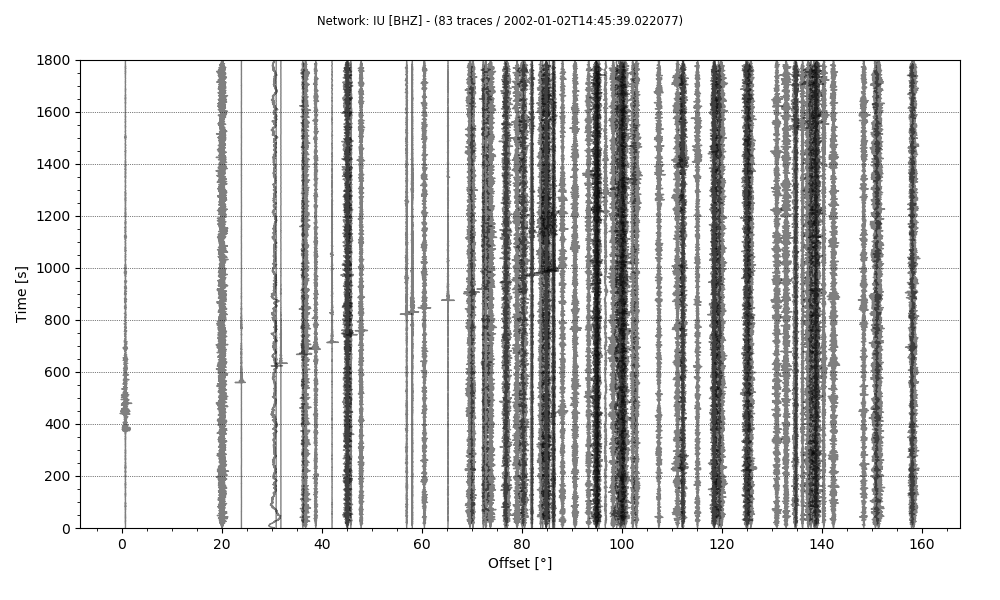

<IPython.core.display.Javascript object>


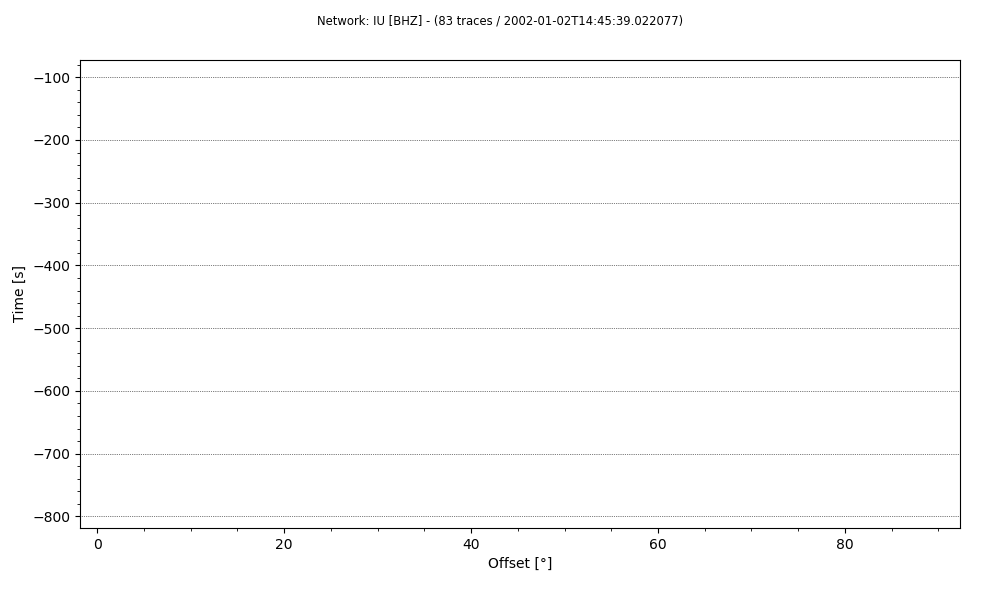

In [11]:
%matplotlib notebook
stream.plot(ev_coord=event_coordinates,type='section',dist_degree=True)

In [6]:
print(stream[0].stats)


         network: IC
         station: BJT
        location: 00
         channel: BHZ
       starttime: 2002-01-02T14:45:39.060043Z
         endtime: 2002-01-02T15:15:39.010043Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 36000
           calib: 1.0
         _format: MSEED
     coordinates: AttribDict({'latitude': 40.018299, 'longitude': 116.1679})
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 11, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 4182016})
      processing: ["ObsPy 1.1.1: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x122db9278>::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", 'ObsPy 1.1.1: normalize(norm=None)']


46.958698